# The Cart Pole Environment
Let's take what we've learned and try it out on the [Cart Pole environment](https://gym.openai.com/envs/CartPole-v1/).

In [266]:
import numpy as np
import gym
from util import log_progress

In [6]:
env = gym.make('CartPole-v1')
observation = env.reset()
env.render()

True

In [12]:
env.close()

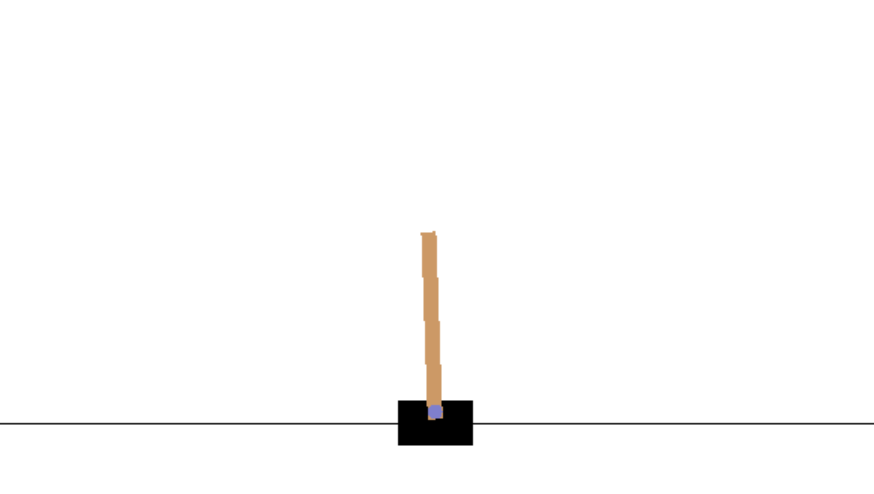

The idea here is there's a cart you can move left or right, and a pole mounted to a joint.  The agent gets rewards each step the pole is above center.  The episode ends if the cart moves too far to the left or right, or if the pole gets more than 15 degrees from vertical.

Let's set up some supporting infrastructure to run an agent:
 * **Episode** will store the history of everything that happened in one episode, which we can use later for *experience replay* training.
 * **Policy** is a class we'll use that will make all the decisions for an agent. We'll start by implementing a minimal policy that makes random decisions. Later we'll make a better policy class.
 * **Agent** is everything else that an agent needs to do other than thinking and remembering.

In [2]:
class Episode:
    """Tracks the history of what happened in a playthrough for experience replay."""
    def __init__(self):
        self.steps = [] # For each time step, a tuple of (state, action, reward)
        self.got_reward = False
    
    def record_step(self, state, action, reward):
        step = (state, action, reward)
        self.steps.append(step)
        if reward > -1:
            self.got_reward = True

    def __len__(self):
        return len(self.steps)

In [38]:
class RandomPolicy:            
    def __init__(self, env):
        self.env = env

    def suggest_action(self, state):
        return self.env.action_space.sample()
    
    def update_step(self, prev_state, prev_action, reward, state, action):
        pass

In [293]:
class Agent:
    max_steps_per_episode = 1000
    
    def __init__(self, env, policy):
        self.env = env
        self.policy = policy
    
    def run_episode(self, render=False):
        episode = Episode()
        state = env.reset()
        action = None
        for i in range(self.max_steps_per_episode):
            prev_state = state
            prev_action = action
            action = self.policy.suggest_action(state)
            state, reward, done, _ = env.step(action)
            episode.record_step(state, action, reward)
            if render:
                self.env.render()
            if prev_action != None:
                self.policy.update_step(prev_state, prev_action, reward, state, action)
            if done:
                self.policy.update_step(prev_state, prev_action, 0, state, action)
                break
        return episode
    
    def train(self, episodes=100, render=False):
        episode_lengths = []
        for i in log_progress(range(episodes), name='Episodes'):
            episode = self.run_episode(render=render)
            episode_lengths.append(len(episode))
        plot_episode_lengths(episode_lengths)
        print('Max length=%f avg=%f' % (np.max(episode_lengths), np.mean(episode_lengths)))

In [262]:
import matplotlib.pyplot as plt
def plot_episode_lengths(episode_lengths):
    # Plot the episode length over time
    fig1 = plt.figure(figsize=(10,5))
    plt.plot(episode_lengths)
    plt.xlabel("Episode")
    plt.ylabel("Episode Length")
    plt.title("Episode Length over Time")
    plt.show(fig1)

We've got a working version of our basic infrastructure that handles everything other than the thinking and learning.  Let's try it out.

In [243]:
agent = Agent(env, RandomPolicy(env))
episode = agent.run_episode(render=True)

In [244]:
env.close()

# Learning

Now that we have our basic infrastructure done let's do some actual learning.  The actual learning breaks down into two main components:
 * Neural net function approximator
 * Q Learning Policy

## Neural Net
We're going to need a function approximator. We'll use a neural net for that using the approach desribed in notebook 3, *Neural Net Approximation*.  We will put the function approximator in its own class, because this is a switchable component.  Neural nets are just one way of doing function approximation, and we might want to try some other ways.  It's also nice to keep the function approximation code separate from the Q learning code, to keep the different parts of the code easier to understand.  Plus, keeping them separate makes it easier to test and improve the components  separately from each other.

For example, I think I might want to add dropout and L2 regularization to the neural network later.  Having it as a separate component lets me do that and compare the results of the improved approximator versus the vanilla approximator.

In [162]:
from keras.models import Sequential
from keras.layers import Dense # Dropout, BatchNormalization
from keras.optimizers import Adam

class Approximator:
    """A function approximator implemented with a deep neural net."""
    def __init__(self, num_inputs, num_outputs, learning_rate=0.01):
        self.model = Sequential()
        self.model.add(Dense(32, input_shape=(num_inputs,), activation='relu'))
        #self.model.add(Dense(64, activation='relu'))
        self.model.add(Dense(64, activation='relu'))
        self.model.add(Dense(num_outputs, activation='linear'))

        adam = Adam(lr=0.011, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
        self.model.compile(optimizer=adam, loss='mse', metrics=['mse'])

    def predict_multi(self, X_batch):
        """Predict the outputs for multiple input values at once.
        X_batch: an np array of m number of X values to predict, of shape (num_inputs, m)
        where m is the number of items you'd like to predict.
        """
        return self.model.predict(X_batch)
    
    def train_multi(self, X, Y, batch_size=16, epochs=1, verbose=0):
        """
        Train the model with m samples.
        X: the input values, of shape (num_inputs, m)
        Y: the target values, of shape (num_outputs, m)
        """
        self.model.fit(X, Y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    
    def predict(self, X):
        """Predict a single output given a single input.
        X: one set of X values to predict. X shape is (num_inputs,).
        """
        predictions = self.predict_multi(np.array([X])) # An array for m input values.
        return predictions[0] # We're just doing one here.
    
    def train(self, X, Y):
        """Train a single input/output pair.
        X: inputs of shape (num_inputs,)
        Y: target outputs of shape (num_outputs,)"""
        batch_X = np.array([X])
        batch_Y = np.array([Y])
        self.train_multi(batch_X, batch_Y, batch_size=1)

In [163]:
ap = Approximator(num_inputs=4, num_outputs=2)
X = np.array([[1,2,3,4], [1,1,1,1]])
ap.predict_multi(X)

array([[0.03850013, 0.13595746],
       [0.00453069, 0.01712409]], dtype=float32)

In [164]:
ap.predict(np.array([1,2,3,4]))

array([0.03850013, 0.13595746], dtype=float32)

Now we'll train the outputs to be closer to [9,12]:

In [165]:
ap.train(np.array([1,2,3,4]), np.array([9, 12]))

In [166]:
ap.predict(np.array([1,2,3,4]))

array([0.16851804, 0.45982698], dtype=float32)

## To do
 - [ ] Shouldn't the current step number impact the expected sum of rewards from here?
 

## Deep Q Learning

In [312]:
class DeepQPolicy:            
    def __init__(self, env, learning_rate=0.02, epsilon=0.05, gamma=0.9):
        """epsilon: probability of exploring by selecting a random action
        gamma: Discount factor for future rewards. Between 0 - 1.
        learning_rate: learning rate for the approximator
        """
        self.env = env
        self.epsilon = epsilon
        self.gamma = gamma # Discount factor for future rewards.
        self.action_list = list(range(self.env.action_space.n)) # All possible actions, like [0,1].
        # Function approximator:
        # Inputs: state
        # Outputs: for each possible action, discounted sum of expected rewards
        num_inputs = env.observation_space.shape[0]
        num_outputs = len(self.action_list)
        self.model = Approximator(num_inputs, num_outputs, learning_rate)

    def suggest_action(self, state, epsilon=None):
        if epsilon == None:
            epsilon = self.epsilon
        if np.random.rand() <= epsilon:
            return self.env.action_space.sample()

        rewards_by_state = self.model.predict(state) # One reward prediction for each possible action.
        action = np.argmax(rewards_by_state) # Index of the best action.
        return action

    def update_step(self, prev_state, prev_action, reward, state, action):
        """Update the approximations of the reward function.
        See Sutton p. 130 formula 6.7
        """
        q_prev_all = self.model.predict(prev_state) # An array with 1 prediction per possible action.
        q_prev = q_prev_all[prev_action] # Predicted value for the action we took.
        next_rewards_all = self.model.predict(state) # Rewards for all possible next actions.
        next_rewards = next_rewards_all[action] # Rewards for the action we will take.
        
        q_target = reward + self.gamma * next_rewards
        q_target_all = np.copy(q_prev_all)  # q_prev_all target for selected prev_action.
        q_target_all[prev_action] = q_target
        self.model.train(prev_state, q_target_all)
        after_train = self.model.predict(prev_state)
        #print('next_rewards_all',next_rewards_all)
        #print('q_prev_all',q_prev_all)
        #print('prev_action',prev_action)
        #print('q_prev',q_prev)
        #print('q_target',q_target)
        #print('next_rewards',next_rewards)
        #print(reward)
        #print('q_target=%f next_rewards=%f q_prev=%f reward=%f' % (q_target, next_rewards, q_prev, reward))
        #print('next_rewards was',next_rewards)
        #print('training to ',q_target_all)
        #print('old prediction', q_prev_all)
        #print ('new prediction', after_train)

## Deep Learning Agent

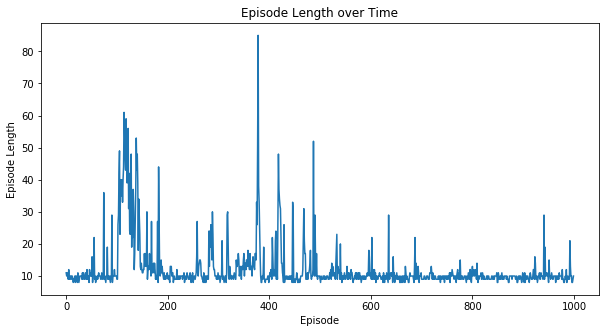

Max length=85.000000 avg=12.399000


In [329]:
agent = Agent(env, DeepQPolicy(env))
agent.train(render=False, episodes=1000)

In [318]:
def peek():
    state = env.reset()
    return agent.policy.model.predict(state)
peek()

array([2.2339203, 3.1024752], dtype=float32)

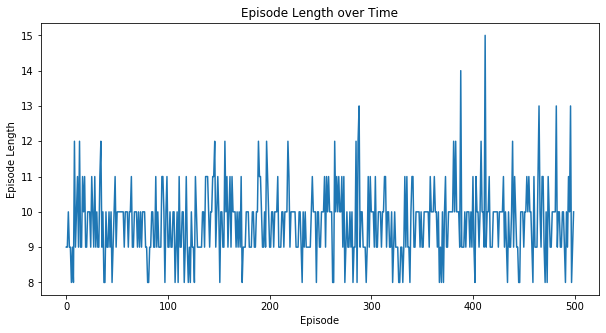

Max length=15.000000 avg=9.714000


In [330]:
agent.train(render=False, episodes=500)

In [311]:
env.close()

In [321]:
from collections import deque
d = deque(maxlen=3)
d.append(1)

In [328]:
list(d)

[3, 2, 3]

In [327]:
d.append(2)
d.append(3)